In [1]:
from spkit import bkt
import pandas as pd
import re
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pickle

### Reading created files

In [2]:
folder = 'data/kdd/2008-2009'

### Preprocessing
Transform dataframe in a format understood by the BKT module

In [4]:
with open('%s/kdd_2008_2009_train_data.pkl' % folder, 'rb') as pklfile:
    data = pickle.load(pklfile)
with open('%s/kdd_2008_2009_q_matrix.pkl' % folder, 'rb') as pklfile:
    q_matrix = pickle.load(pklfile)
with open('%s/kdd_2008_2009_students.pkl' % folder, 'rb') as pklfile:
    students = pickle.load(pklfile)
with open('%s/kdd_2008_2009_kcs.pkl' % folder, 'rb') as pklfile:
    kcs = pickle.load(pklfile)

## Fit model

In [5]:
%%time
# Instantiate model
model = bkt.BKT()
model.fit(data, q_matrix)

Wall time: 4min 16s


In [8]:
with open('%s/kdd_2008_2009_bkt_model.pkl' % folder, 'wb') as pklfile:
    pickle.dump(model, pklfile)

### Calculate score

In [7]:
%%time
data_arr = np.asarray(data)
rmse = 0
n = 0
score_df = []
learning_state = {}
outcome_all = []
predicted_proba = []
for student in students:
    student_idx = np.where(data_arr[:,1] == student)
    outcome = data_arr[student_idx, 0].astype('int64')
    outcome_all += outcome.tolist()[0]
    question_id = data_arr[student_idx, 2].astype('int64')
    data_student = np.vstack((outcome, question_id)).T.astype('int64').tolist()
    predicted = model.predict_proba(data_student, q_matrix)
    predicted_proba += predicted[:,1].tolist()
    s_ll, s_aic, s_bic, s_rmse, s_acc = model.score()
    fpr, tpr, _ = roc_curve(outcome.flatten(), predicted[:,1], pos_label=1)
    auc_score = auc(fpr, tpr)
    score_df.append({"student": student,
                     "AIC": s_aic,
                     "BIC": s_bic,
                     "RMSE": s_rmse,
                     "Acc": s_acc,
                     "n questions": model.n_questions,
                     "LL": s_ll,
                     "correct_outcome": np.where(outcome == 1)[1].shape[0],
                     "incorrect_outcome": np.where(outcome == 0)[1].shape[0],
                     "AUC": auc_score})
    learning_state[student] = model.get_learning_state()

C:\Users\lmoraes\Miniconda3\envs\py3\lib\site-packages\sklearn\metrics\ranking.py:651: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)
C:\Users\lmoraes\Miniconda3\envs\py3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\Users\lmoraes\Miniconda3\envs\py3\lib\site-packages\sklearn\metrics\ranking.py:659: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


Wall time: 19min 52s


In [9]:
score = pd.DataFrame.from_dict(score_df)

In [10]:
with open('%s/kdd_2008_2009_bkt_score.pkl' % folder, 'wb') as pklfile:
    pickle.dump(score, pklfile)
with open('%s/kdd_2008_2009_bkt_learning_state.pkl' % folder, 'wb') as pklfile:
    pickle.dump(learning_state, pklfile)

In [11]:
rmse_train = np.sqrt((score['RMSE']**2*score['n questions']).sum()/score['n questions'].sum())
rmse_avg = score['RMSE'].mean()
rmse_std = score['RMSE'].std()

In [12]:
print("RMSE de treino: %.2f" % rmse_train)
print("RMSE médio: %.2f +- %.2f" % (rmse_avg, rmse_std))

RMSE de treino: 0.36
RMSE médio: 0.40 +- 0.07


In [13]:
acc_train = (score['Acc']*score['n questions']).sum()/score['n questions'].sum()
acc_avg = score['Acc'].mean()
acc_std = score['Acc'].std()

In [14]:
print("Acc de treino: %.2f" % acc_train)
print("Acc médio: %.2f +- %.2f" % (acc_avg, acc_std))

Acc de treino: 0.81
Acc médio: 0.74 +- 0.15


In [15]:
fpr, tpr, thresholds = roc_curve(outcome_all, predicted_proba, pos_label=1)
auc_score = auc(fpr, tpr)
auc_avg = score['AUC'].mean()
auc_std = score['AUC'].std()

# Sensitivity = tpr = TP/(TP+FN)
# Specificity = 1-fpr = TN/(TN+FP)
# Youden's index = Sensitivity + Specificity - 1 = tpr + (1-fpr) - 1 = tpr - fpr
J_stats = tpr - fpr
J_opt_thresholds = thresholds[np.argmax(J_stats)]
print('Youden\'s optimum threshold: %.2f' % J_opt_thresholds)

Youden's optimum threshold: 0.83


In [16]:
print("AUC de treino: %.2f" % auc_score)
print("AUC médio: %.2f +- %.2f" % (auc_avg, auc_std))

AUC de treino: 0.73
AUC médio: 0.69 +- 0.09


Recalculating accuracy after adjusting cutoff point with Youden's Index

In [17]:
estimated_outcome = np.where(np.asarray(predicted_proba) > J_opt_thresholds, 1, 0)
acc = (estimated_outcome == np.asarray(outcome_all)).sum()/score['n questions'].sum()
acc

0.6294184678158816

In [18]:
# Save threshold
with open('%s/kdd_2008_2009_bkt_threshold.pkl' % folder, 'wb') as pklfile:
    pickle.dump(J_opt_thresholds, pklfile)

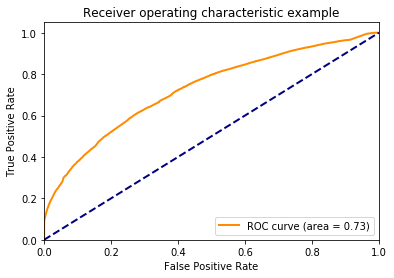

In [19]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Comparing accuracy to random baseline

In [20]:
n_questions = score['n questions'].sum()
p = score['correct_outcome'].sum()/n_questions
# Save p
with open('%s/kdd_2008_2009_bkt_p.pkl' % folder, 'wb') as pklfile:
    pickle.dump(p, pklfile)

estimated_outcome = np.random.binomial(1, p, n_questions)
acc = (estimated_outcome == np.asarray(outcome_all)).sum()/score['n questions'].sum()
acc

0.7383793607618093

In [21]:
score.sort_values(["AUC"], ascending=False)

,student,AIC,BIC,RMSE,Acc,n questions,LL,correct_outcome,incorrect_outcome,AUC
312,h4N48ldyLn,911.648029,1542.602399,0.419527,0.677419,31,-15.824014,19,12,0.890351
570,w0FMzJORlK,1056.276865,2610.968240,0.321204,0.865613,253,-88.138432,227,26,0.875297
520,k71nQKqIB3,913.672191,1280.286062,0.625189,0.176471,17,-16.836095,14,3,0.857143
411,b4WRCgbjkN,1594.558794,3597.662264,0.406271,0.796006,701,-357.279397,302,399,0.856010
370,h31E235Th5,966.691522,1936.756274,0.486018,0.552239,67,-43.345761,49,18,0.837868
...,...,...,...,...,...,...,...,...,...,...
284,XBhl87k165,925.561312,1461.866675,0.594953,0.200000,25,-22.780656,19,6,0.219298
46,6dGeA2ZpO4,899.074017,1032.211458,0.609739,0.300000,10,-9.537009,7,3,0.190476
174,X223hIsDU4,898.719986,933.674264,0.689401,0.000000,8,-9.359993,8,0,NaN
190,EpDb06UO89,956.604856,1761.207070,0.565122,0.347826,46,-38.302428,46,0,NaN


In [22]:
score.sort_values(["Acc"], ascending=False)

,student,AIC,BIC,RMSE,Acc,n questions,LL,correct_outcome,incorrect_outcome,AUC
193,hwF4tyWU50,2461.291993,4963.203407,0.327767,0.865932,2178,-790.645997,1956,222,0.718024
570,w0FMzJORlK,1056.276865,2610.968240,0.321204,0.865613,253,-88.138432,227,26,0.875297
41,mNzo8mGzu9,2497.059757,4989.785033,0.338710,0.854665,2133,-808.529878,1883,250,0.715512
92,5x5fHvFFLv,1877.660522,4167.813227,0.334378,0.849926,1346,-498.830261,1217,129,0.710554
362,YvD7H8XduF,1732.633721,3941.517633,0.338708,0.848972,1119,-426.316861,995,124,0.721863
...,...,...,...,...,...,...,...,...,...,...
462,XkcoMK8tfF,909.952517,1249.891555,0.606269,0.187500,16,-14.976259,16,0,NaN
255,68xd8R3v7U,902.337864,1077.411784,0.633619,0.181818,11,-11.168932,9,2,0.638889
520,k71nQKqIB3,913.672191,1280.286062,0.625189,0.176471,17,-16.836095,14,3,0.857143
146,4k3099QrCN,894.771387,870.971853,0.648615,0.142857,7,-7.385694,6,1,0.333333
